# Clustering algorithms

`Unsupervised learning I` `Author: Emily Hunt`

## Introduction

### A primer on unsupervised ML

We saw yesterday how **supervised machine learning** is an extremely powerful tool for solving many problems in astronomy. But what should we do if we don't have training data?

**Unsupervised machine learning** is a family of methods that can allow for classification and regression **without** training data. Instead, they use a number of **tunable parameters** to control how they (attempt to) extract features from data.

This makes them into a great family of methods for blind (unbiased) data exploration. However, we'll also learn how unsupervised approaches are only as good as the algorithm they use or the parameters you set, and we'll learn about how fiddly and unreliable they can also be to use. As with any method in astronomy: batteries are not included! (Which is to say, you have to use them carefully.)

### Clustering algorithms

**Clustering algorithms** are a family of unsupervised methods that can extract natural clusters from data. This makes them somewhat analogous to supervised classifiers, as they 'classify' your data into different clusters. However, this is only possible by assuming that your data _is_ clustered in some way. If your dataset doesn't have well-separated classes, applying clustering algorithms is a lot harder.

They also typically work best on low-dimensionality data (up to ~10-50 dimensions), so you can't apply a clustering algorithm to a more complicated type of data (like images) without some kind of preprocessing.

Clustering algorithms do have some benefits. For instance, some algorithms - especially **density-based** ones - can also be used for outlier detection / noise removal: being able to classify something as not being a member of _any_ class is a desirable property.

### The wide range of clustering algorithms

In this tutorial, we'll just be using the clustering algorithms available in [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html). At the time of writing, it includes **twelve** different algorithms, each with different pros and cons.

The following graphic from the scikit-learn docs shows the twelve different algorithms applied to different kinds of (2D) data:

<div>
    <img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" width="600"/>
</div>

It's already apparent that each algorithm does better or worse for different types of data.

It can be difficult to put many clustering algorithms in one 'box', as many methods have similar (and different) properties, but most algorithms have one or more of the following properties:

- **Centroid-fitting** algorithms (like K-Means, Gaussian mixture models) perform iterative steps to find natural centers of clusters
- **Hierarchical algorithms** (the AgglomerativeClustering family of methods in scikit-learn) try to find hierarchy in a dataset and use some heuristic to decide how much subclustering to accept
- **Density-based algorithms** (DBSCAN, OPTICS, HDBSCAN) use the distances between points as an approximation of local density, in conjunction with a few parameters to decide which clusters to extract.

## Imports, dependencies, & basic helpers

In [4]:
# Uncomment the below to install packages you will need, if necessary.
# !pip install scikit-learn numpy<2.0 pandas astropy astroquery pyarrow

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import (
    KMeans,
    SpectralClustering,
    AgglomerativeClustering,
    DBSCAN,
    HDBSCAN,
)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_blobs, make_moons
from astropy import table as at
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from pathlib import Path

In [366]:
def plot_clusters(
    data: np.ndarray,
    labels: np.ndarray | None = None,
    probabilities: np.ndarray | None = None,
    cmap: str = "tab10",
    noise_alpha: float = 0.5,
    figure_kwargs: dict | None = None,
    scatter_kwargs: dict | None = None,
    x_column: int = 0,
    y_column: int = 1,
    title: str = "",
    algorithm=None,
):
    """Plots a default scikit-learn clustering result, or a dataset when true labels
    are known.
    """
    if figure_kwargs is None:
        figure_kwargs = dict()
    if scatter_kwargs is None:
        scatter_kwargs = dict()

    colors = "k"
    if labels is not None:
        # Small trick to get colours for each cluster from any discrete matplotlib colormap
        colors = plt.get_cmap(cmap)(labels)

        # Add probabilities too
        if probabilities is not None:
            colors[:, -1] = probabilities

        # Replace 'noise' points (with a label of -1) with black
        bad_labels = labels == -1
        colors[bad_labels] = np.tile(
            (0.0, 0.0, 0.0, noise_alpha), (bad_labels.sum(), 1)
        )

    # Make the plot
    fig, ax = plt.subplots(**figure_kwargs)
    ax.scatter(data[:, x_column], data[:, y_column], c=colors, **scatter_kwargs)

    ax.set(xlabel=f"$x_{x_column}$", ylabel=f"$x_{y_column}$", title=title)
    if algorithm is not None:
        ax.set_title(
            str(algorithm.__class__).rsplit(".")[-1][:-2] + " " + title
        )
    else:
        ax.set_title(title)

    return fig, ax

In [399]:
def plot_open_cluster(
    data_gaia: pd.DataFrame,
    labels: np.ndarray | None = None,
    probabilities: np.ndarray | None = None,
    cmap: str = "tab10",
    noise_alpha: float = 0.1,
    figure_kwargs: dict | None = None,
    scatter_kwargs: dict | None = None,
    title: str = "",
    algorithm=None,
    proper_motion_range=(-30, 30),
    parallax_range=(0, 10),
):
    """Plots a default scikit-learn clustering result, or a dataset when true labels
    are known. Modified to work with Gaia data of open clusters for exercise 3.
    """
    if figure_kwargs is None:
        figure_kwargs = dict()
    figure_kwargs_to_use = dict(ncols=4, figsize=(12, 3.5))
    figure_kwargs_to_use.update(**figure_kwargs)

    if scatter_kwargs is None:
        scatter_kwargs = dict()
    scatter_kwargs_to_use = dict(s=5, linewidths=0.0)
    scatter_kwargs_to_use.update(**scatter_kwargs)

    colors = np.zeros((len(data_gaia), 4), dtype=float)
    colors[:, -1] = 1.
    bad_labels = np.ones(len(data_gaia), dtype=bool)
    if labels is not None:
        # Small trick to get colours for each cluster from any discrete matplotlib colormap
        colors = plt.get_cmap(cmap)(labels)

        # Add probabilities too
        if probabilities is not None:
            colors[:, -1] = probabilities

        # Replace 'noise' points (with a label of -1) with black
        bad_labels = labels == -1
        colors[bad_labels] = np.tile(
            (0.0, 0.0, 0.0, noise_alpha), (bad_labels.sum(), 1)
        )

    # Make the plot
    fig, ax = plt.subplots(**figure_kwargs_to_use)
    for a_labels in (bad_labels, np.invert(bad_labels)):
        ax[0].scatter(
            data_gaia.loc[a_labels, "lon"],
            data_gaia.loc[a_labels, "lat"],
            c=colors[a_labels],
            **scatter_kwargs_to_use,
        )
        ax[1].scatter(
            data_gaia.loc[a_labels, "pmlon"],
            data_gaia.loc[a_labels, "pmlat"],
            c=colors[a_labels],
            **scatter_kwargs_to_use,
        )
        ax[2].scatter(
            data_gaia.loc[a_labels, "lon"],
            data_gaia.loc[a_labels, "parallax"],
            c=colors[a_labels],
            **scatter_kwargs_to_use,
        )
        ax[3].scatter(
            data_gaia.loc[a_labels, "bp_rp"],
            data_gaia.loc[a_labels, "phot_g_mean_mag"],
            c=colors[a_labels],
            **scatter_kwargs_to_use,
        )
    ax[3].invert_yaxis()
    ax[0].set(xlabel="lon", ylabel="lat")
    ax[1].set(
        xlabel="pmlon",
        ylabel="pmlat",
        xlim=proper_motion_range,
        ylim=proper_motion_range,
    )
    ax[2].set(xlabel="lon", ylabel="parallax", ylim=parallax_range)
    ax[3].set(xlabel="BP - RP", ylabel="G")

    fig.tight_layout()

    if algorithm is not None:
        fig.suptitle(str(algorithm.__class__).rsplit(".")[-1][:-2] + " " + title, y=1.0)
    else:
        fig.suptitle(title, y=1.0)

    return fig, ax

## How to use the clustering algorithms in scikit-learn

scikit-learn is a great 'one-stop-shop' for popular clustering algorithms that can solve many different problems. It has a very consistent API*, making it easy to try different algorithms.

*API - _'application programming interface'_: the fancy name for how its interface to everything it can do is set up

Let's make a basic 2D test dataset of a few Gaussians to demonstrate this:

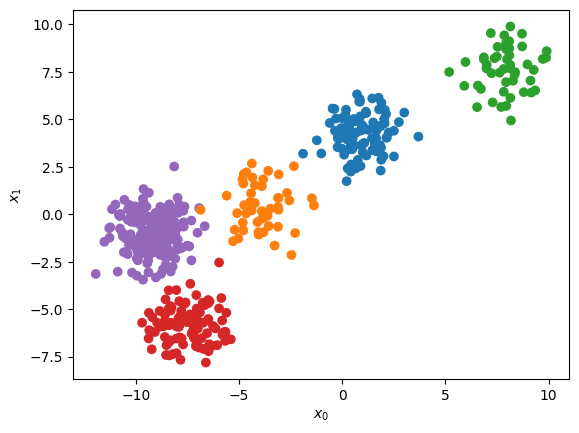

In [3]:
# Parameters
seed = 3  # It's a very good idea to always use a set seed for reproducibility
dimensions = 2
cluster_sizes = [100, 50, 50, 100, 200]

# Make the data
data, true_labels = make_blobs(n_samples=cluster_sizes, n_features=2, random_state=seed)

_ = plot_clusters(data, true_labels)

Applying a clustering algorithm with scikit-learn is easy. Firstly, [look it up in the documentation](https://scikit-learn.org/stable/modules/clustering.html) to work out which parameters it needs. We'll try the easiest one - [K Means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) - which has a single parameter, the number of clusters n_clusters.

The method starts with a random initialization - for reproducibility, we'll make sure to set it to something consistent.

We start by initializing a clustering object:

In [4]:
clusterer = KMeans(n_clusters=5, random_state=42)

Then, we can use the fit_predict method to both fit the algorithm _and_ predict labels for our data (a shorthand for calling `predict(fit(...))`). The data needs to have shape `n_samples, n_features` (i.e. number of points, number of dimensions):

In [5]:
print(f"Data shape: {data.shape}")

labels = clusterer.fit_predict(data)

Data shape: (500, 2)


All clustering algorithms produce an array of _labels_, which tell you the algorithm's predicted class for the object. Let's look at the predicted labels for the first ten:

In [6]:
labels[:10]

array([3, 4, 0, 3, 3, 0, 3, 3, 4, 3], dtype=int32)

It put them all in the same cluster, which is good!

Some algorithms also predict the probability that a given point is in a cluster. In that way, points can actually be a member of multiple clusters (this is especially the case for Gaussian mixtures.)

Let's plot the output:

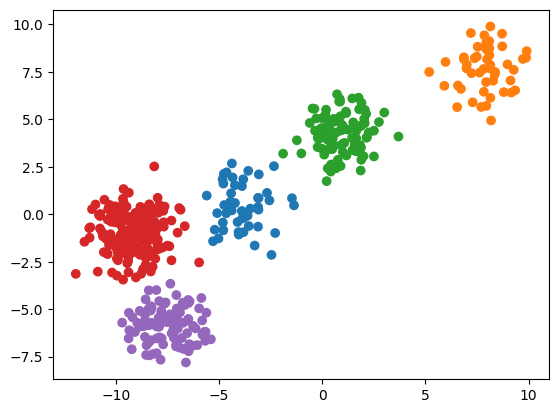

In [7]:
plt.scatter(data[:, 0], data[:, 1], color=plt.get_cmap("tab10")(labels))

Perfect! It correctly identified all five clusters we put into the dataset.

If using clustering algorithms was always easy, this is where the tutorial would stop. But alas, it often isn't; and can require making informed choices about the algorithm you use and the parameters you pick.

## EXERCISE 1: trying out different clustering algorithms

### Test dataset

Let's start by trying a few different algorithms on a test dataset. Let's focus on a few popular ones. I've put their most important parameters below for this exercise:

* `KMeans(n_clusters=int, random_state=...)`
* `SpectralClustering(n_clusters=int, random_state=...)`
* `AgglomerativeClustering(n_clusters=int, linkage={‘ward’, ‘complete’, ‘average’, ‘single’})`
* `DBSCAN(eps=float, min_samples=int)`
* `HDBSCAN(min_cluster_size=int, min_samples=int)`
* `GaussianMixture(n_components=int, covariance_type={‘full’, ‘tied’, ‘diag’, ‘spherical’})`

(You can find out more about them in [the docs](https://scikit-learn.org/stable/modules/clustering.html).)

Let's make a somewhat more challenging test dataset, containing a few overlapping clusters.

[Text(0.5, 1.0, 'Ground truth for Exercise 1!')]

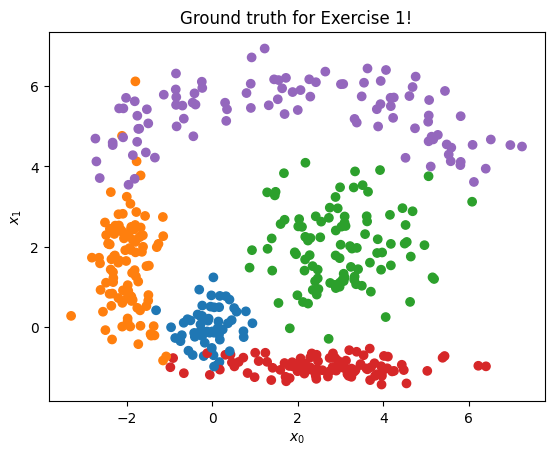

In [8]:
data_blobs, blob_labels = make_blobs(
    n_samples=[60, 100, 100, 100],
    random_state=42,
    centers=[[0, 0], [-2.0, 0.5], [3, 2.0], [0.4, -1]],
    cluster_std=[0.5, 0.4, 1, 0.2],
)
# Warp the blobs a bit
data_blobs[blob_labels == 1, 1] *= 3
data_blobs[blob_labels == 3, 0] *= 7

# Also add a moon
data_curve = make_moons(n_samples=200, shuffle=False, noise=0.2, random_state=42)[0][
    :100
]
data_curve = data_curve * np.asarray([[4, 2]]) + np.asarray([[2, 4]])
curve_labels = np.full(100, 4)

# Put it all together!
data = np.vstack(
    [
        data_blobs,
        data_curve,
    ]
)
true_labels = np.concatenate([blob_labels, curve_labels])
fig, ax = plot_clusters(data, true_labels)
ax.set(title="Ground truth for Exercise 1!")

This is already a pretty non-trivial dataset to cluster. Here's an example of trying it with KMeans:

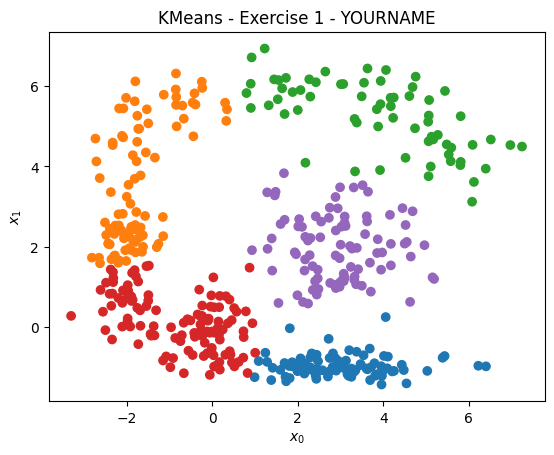

In [10]:
clusterer = KMeans(n_clusters=5)
labels = clusterer.fit_predict(data)
fig, ax = plot_clusters(
    data, labels, algorithm=clusterer, title="- Exercise 1 - YOURNAME"
)

### Your turn!

**Try different clustering algorithms from the list above and see what results you get.** (They are all already imported.)

## EXERCISE 2: $[\alpha/\text{Fe}]$ vs. $[\text{Fe}/\text{H}]$

There's one thing that made the last exercise a lot easier: **we already knew the answer**. This is good for demonstration purposes! But in the next sections, we'll see how using clustering algorithms gets harder for data we don't know as much about.

### APOGEE dataset

Let's look at metallicites and alpha abundances for stars in APOGEE as a good example.

In [284]:
# Try to read from local directory; otherwise, get from online source
local_path = Path("../data/apogee-dr17-metallicites-and-alphas-cut.parquet")
url_path = "https://raw.githubusercontent.com/emilyhunt/machine-learning-tutorial-MWGaia-DN/main/data/apogee-dr17-metallicites-and-alphas-cut.parquet"

if local_path.exists():
    apogee = pd.read_parquet(local_path)
else:
    apogee = pd.read_parquet(url_path)

The ratio of alpha-process elements to metallicity follows a particularly interesting trend:

Text(-1.5, 0.15, 'galactic\nhalo')

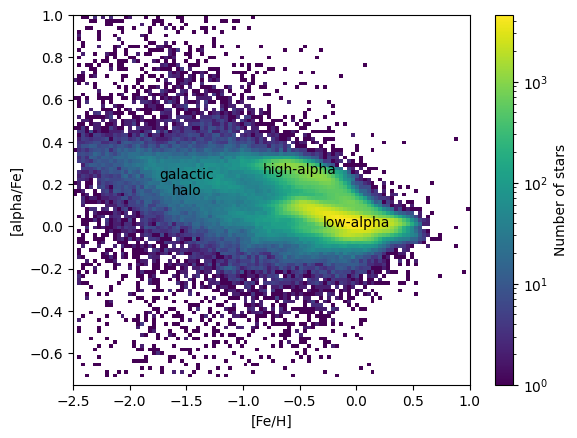

In [276]:
fig, ax = plt.subplots()

points = ax.hist2d(
    apogee["M_H"],
    apogee["ALPHA_M"],
    range=((-2.5, 1), (-0.75, 1.0)),
    cmin=1,
    bins=100,
    norm=mpl.colors.LogNorm(),
)
fig.colorbar(points[-1], label="Number of stars")
ax.set(xlabel="[Fe/H]", ylabel="[alpha/Fe]")
ax.text(0, 0, "low-alpha", color="k", ha="center")
ax.text(-0.5, 0.25, "high-alpha", color="k", ha="center")
ax.text(-1.5, 0.15, "galactic\nhalo", color="k", ha="center")

There are ~three distinct groups of stars. There is a clear large group of low-alpha and high-alpha stars, and also some with generally high alpha and lower metallicity (largely in the galactic halo.) The position of a star on this diagram can tell us lots of things about the epoch of star formation it was formed in.

**Can we separate them into clusters?**

To make this exercise run faster, let's just use the brightest 10,000 stars in the APOGEE dataset for clustering, and also cut away some outliers in alpha abundances:

In [253]:
apogee_good = (
    apogee.query("ALPHA_M > -0.1 and ALPHA_M < 0.35")
    .reset_index(drop=True)
    .sort_values("J")
    .iloc[:10000]
    .reset_index(drop=True)
)
apogee_data = apogee_good[["M_H", "ALPHA_M"]].to_numpy()

You'll find that this data is not trivial to cluster! Here's a naive example with KMeans clustering that does _not_ work well:

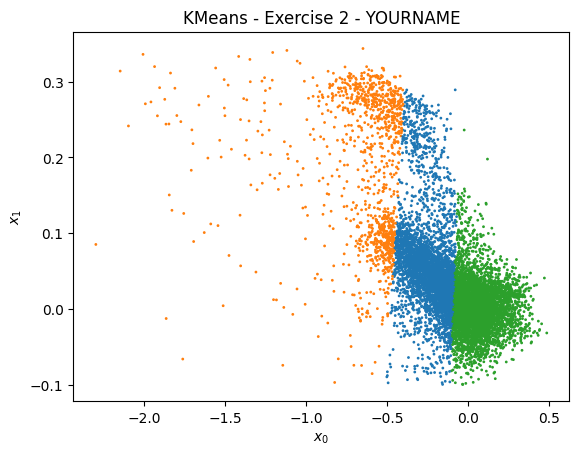

In [274]:
clusterer = KMeans(n_clusters=3, random_state=42)
labels = clusterer.fit_predict(apogee_data)
fig, ax = plot_clusters(
    apogee_data,
    labels,
    algorithm=clusterer,
    title="- Exercise 2 - YOURNAME",
    scatter_kwargs=dict(s=1),
)

### Your turn!

**Try to separate the low alpha, high alpha, and halo stars into clusters.**

Hints:
- Think about which algorithms have the right properties to work with this dataset.
- For algorithms with an `n_clusters` or `n_components` parameter, you may need to set it much higher than the number of clusters you want to find, and imagine that we'd 'merge' subclusters back together at the end.

### Extra, if you have time:

- Try to use your fitted model to predict which group the remaining stars _not_ in our 'training sample' of 10,000 belong to.
- Count how many stars are in each sample.
- Use your classifications to plot the stars by type on the sky (using the `GLON` and `GLAT` columns.) What do you notice?

## EXERCISE 3: open clusters in Gaia data

A tutorial about clustering algorithms wouldn't be complete without a little foray in what I did for my PhD: finding open clusters in Gaia with machine learning!

### Gaia data

Many papers (e.g. Castro-Ginard+18,19,21,22, Liu+19, Cantat-Gaudin+19, Hunt+21,23,24...) have used clustering algorithms to analyse Gaia data. **Just ~0.1% of stars in the Milky Way seem to reside in an open cluster**, so it's like looking for needles in a haystack - but the clusters themselves are extremely useful for many aspects of galactic and stellar science, so they're worth finding =)

To start, let's grab my catalogue and pick a cluster to analyse. (We'll just look for reliable, large OCs.)

In [291]:
hunt_clusters = Vizier(
    catalog="J/A+A/686/A42/clusters", row_limit=-1, columns=["**"]
).query_constraints(CST=">10", Type="o", NJ=">100", MassJ=">200", dist50=">100")[0].to_pandas()

Let's pick a really nice cluster first: Blanco 1 is very far below the galactic plane (GLAT=-79°) and hence doesn't have much background, and it's also pretty nearby and has a few hundred stars:

In [334]:
hunt_clusters.set_index("Name").loc["Blanco_1", ["GLON", "GLAT", "dist50", "N"]]

GLON        14.75758
GLAT      -79.129997
dist50    234.390495
N                841
Name: Blanco_1, dtype: object

I downloaded the data for it already for you:

In [336]:
# Try to read from local directory; otherwise, get from online source
local_path = Path("../data/blanco_1.parquet")
url_path = "https://raw.githubusercontent.com/emilyhunt/machine-learning-tutorial-MWGaia-DN/main/data/blanco_1.parquet"

if local_path.exists():
    gaia_data_blanco_1 = pd.read_parquet(local_path)
else:
    gaia_data_blanco_1 = pd.read_parquet(url_path)

Which has columns:

In [337]:
gaia_data_blanco_1.columns

Index(['SOURCE_ID', 'ra', 'dec', 'pmra', 'pmdec', 'parallax',
       'phot_g_mean_mag', 'bp_rp'],
      dtype='object')

SO! We have our data. Let's plot what it looks like on-sky. It's a good cluster, so it should be obvious! **About 5% of the stars should be in the cluster:**

[Text(0.5, 0, 'ra'), Text(0, 0.5, 'dec')]

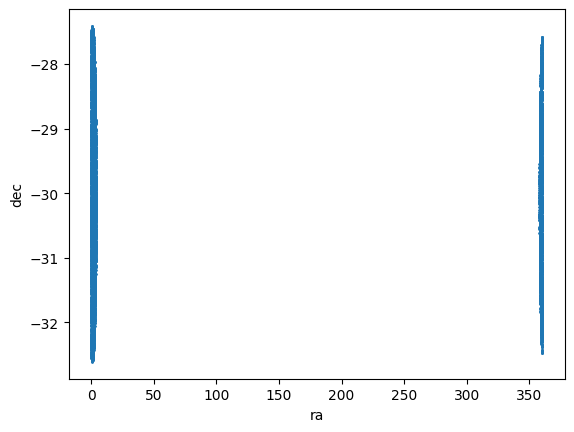

In [342]:
plt.scatter(gaia_data_blanco_1['ra'], gaia_data_blanco_1['dec'], s=1)
plt.gca().set(xlabel="ra", ylabel="dec")

... well that's a shame, it straddles a discontinuity in ra. Not to worry, we can just flip it over:

[Text(0.5, 0, 'ra'), Text(0, 0.5, 'dec')]

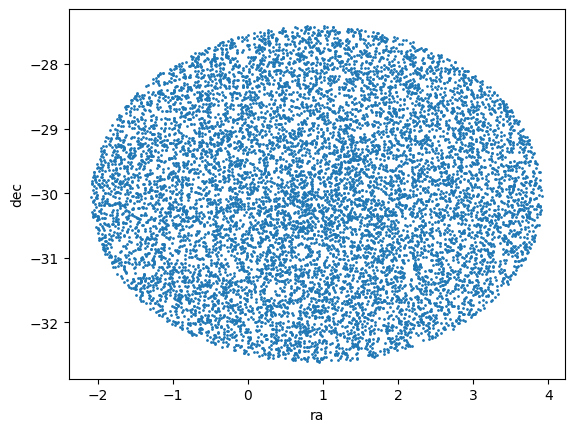

In [341]:
ra_moved = np.where(gaia_data_blanco_1['ra'] > 180, gaia_data_blanco_1['ra'] - 360, gaia_data_blanco_1['ra'])
plt.scatter(ra_moved, gaia_data_blanco_1['dec'], s=1)
plt.gca().set(xlabel="ra", ylabel="dec")

_and here in lies the problem_: it's a needle in a haystack. The cluster isn't at all obvious when looking just at sky coordinates.

Instead, because Gaia is awesome, it has proper motions. It should show up in proper motions:

[Text(0.5, 0, 'ra'), Text(0, 0.5, 'dec')]

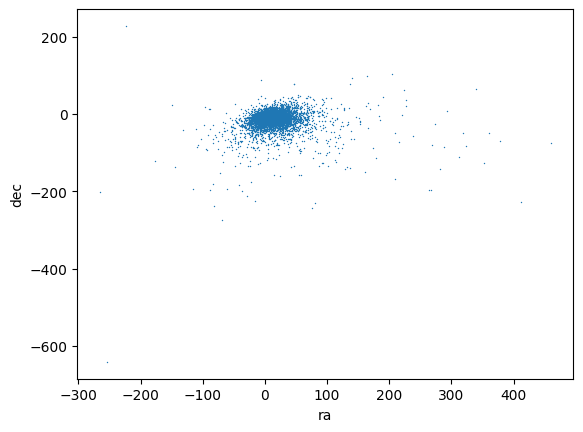

In [344]:
plt.scatter(gaia_data_blanco_1['pmra'], gaia_data_blanco_1['pmdec'], s=1, linewidths=0.)
plt.gca().set(xlabel="ra", ylabel="dec")

🥲 where is the cluster, the blob is just all of the field stars

Maybe if we zoom in???

[Text(0.5, 0, 'ra'), Text(0, 0.5, 'dec'), (-25.0, 25.0), (-25.0, 25.0)]

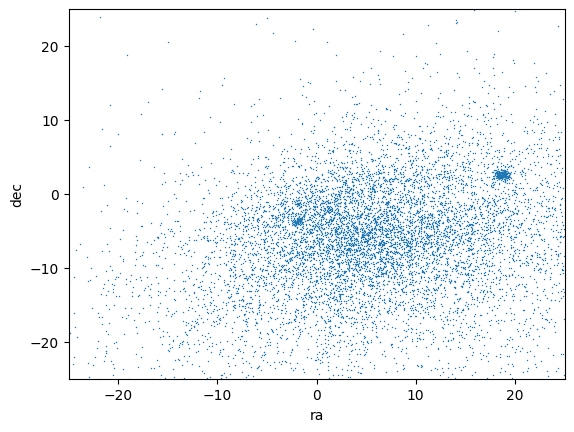

In [346]:
plt.scatter(gaia_data_blanco_1['pmra'], gaia_data_blanco_1['pmdec'], s=1, linewidths=0.)
plt.gca().set(xlabel="ra", ylabel="dec", xlim=(-25, 25), ylim=(-25, 25))

Can you see it?

### Thinking about preprocessing

So far, all of our data has been quite easy to work with because of one particular reason: **everything has the same units**, or **essentially no units at all.**

The data here has **sky positions, proper motions, and parallaxes.** That's five dimensions, in degrees, milliarcseconds / year, and milliarcseconds. How can we use them all together?

`scikit-learn` has a helpful set of [preprocessing tools](https://scikit-learn.org/stable/modules/preprocessing.html) that we can use. We'll make a common assumption in the field (that works, thankfully): we can rescale all the dimensions of our dataset to have **zero mean** and **unit variance**, giving them the same 'weight' in clustering.

I like the `RobustScaler` as it actually uses the median and interquartile range for scaling.

In addition, we can do our clustering in an arbitrary longitude & latitude frame, removing any spherical discontinuities. There's a lovely trick to do this in astropy. Here's a function to preprocess things (taken from the [ocelot](https://github.com/emilyhunt/ocelot) module):

In [353]:
def preprocess_gaia_data(
    gaia_data, cluster_name, columns=("lon", "lat", "pmlon", "pmlat", "parallax")
):
    """Preprocesses Gaia data following the method in Hunt+21 - converting to a centered
    coordinate frame and rescaling.
    """
    cluster_info = hunt_clusters.set_index("Name").loc[cluster_name]

    # Convert Gaia data to coordinate frame on cluster
    cluster_center = SkyCoord(
        cluster_info["RA_ICRS"], cluster_info["DE_ICRS"], unit="deg"
    ).skyoffset_frame()
    coordinates = SkyCoord(
        ra=gaia_data["ra"].to_numpy() * u.deg,
        dec=gaia_data["dec"].to_numpy() * u.deg,
        pm_ra_cosdec=gaia_data["pmra"].to_numpy() * u.mas / u.yr,
        pm_dec=gaia_data["pmdec"].to_numpy() * u.mas / u.yr,
    ).transform_to(cluster_center)

    gaia_data["lon"], gaia_data["lat"], gaia_data["pmlon"], gaia_data["pmlat"] = (
        coordinates.lon.value,
        coordinates.lat.value,
        coordinates.pm_lon_coslat.value,
        coordinates.pm_lat.value,
    )

    # Fit a RobustScaler to rescale it
    scaler = RobustScaler()
    rescaled_data = scaler.fit_transform(gaia_data[list(columns)])
    return rescaled_data


In [354]:
gaia_data_rescaled = preprocess_gaia_data(gaia_data_blanco_1, "Blanco_1")

Now we have some nice longitude, latitude, and proper motion in longitude/latitude columns, all without nasty spherical distortions:

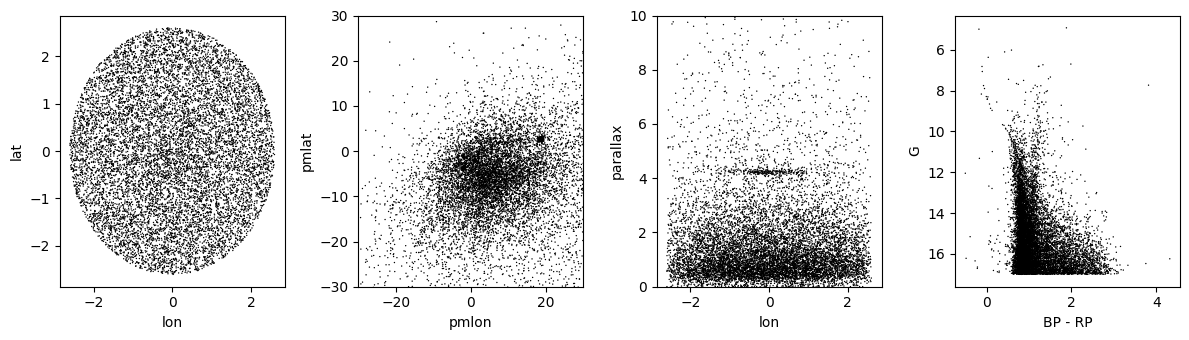

In [401]:
_ = plot_open_cluster(gaia_data_blanco_1, scatter_kwargs=dict(s=1))

And a rescaled set of them to use for clustering! Notice how they all look approximately Gaussian:

[Text(0.5, 1.0, 'Rescaled data')]

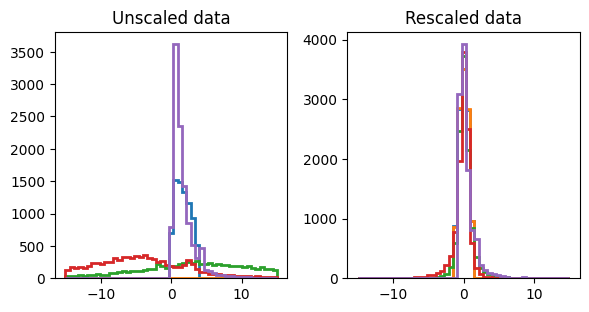

In [408]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))


bins = np.linspace(-15, 15)
for an_unscaled, a_rescaled in zip(
    gaia_data_blanco_1[["ra", "dec", "pmra", "pmdec", "parallax"]].to_numpy().T,
    gaia_data_rescaled.T,
):
    ax[0].hist(an_unscaled, histtype="step", bins=bins, lw=2)
    ax[1].hist(a_rescaled, histtype="step", bins=bins, lw=2)

fig.tight_layout()
ax[0].set(title="Unscaled data")
ax[1].set(title="Rescaled data")

### Example clustering: KMeans

More so than previous times, this really is a problem where some algorithms **do not work.** Let's try KMeans:

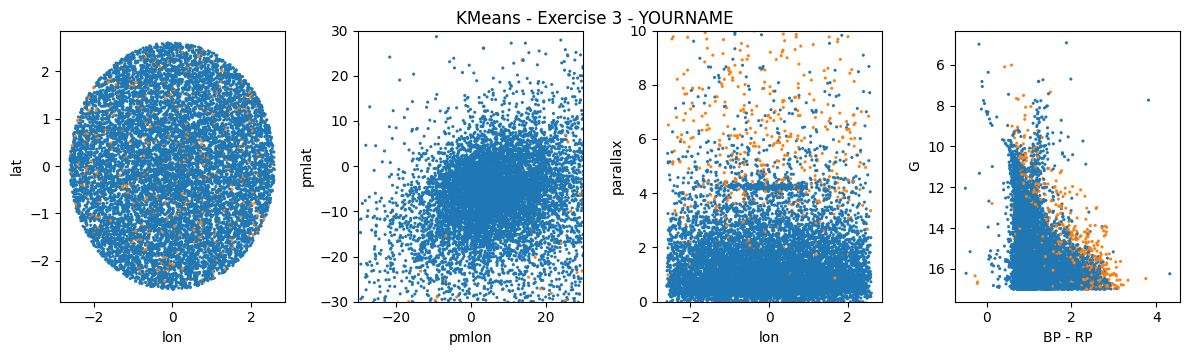

In [409]:
clusterer = KMeans(n_clusters=2, random_state=42)
labels = clusterer.fit_predict(gaia_data_rescaled)
fig, ax = plot_open_cluster(
    gaia_data_blanco_1,
    labels,
    algorithm=clusterer,
    title="- Exercise 3 - YOURNAME",
)

### Your turn

**Try to identify Blanco 1 in the 5-D `gaia_data_rescaled` dataset.**

Hints:
- Most of the data is field stars and _not_ the cluster. Which kind of algorithm might be best this time?
- It can sometimes be better to _not_ use on-sky positions (at least for clusters that are nearby.) You can cluster in just pmra/pmdec/parallax by calling `preprocess_gaia_data` with the extra argument `columns=("pmlon", "pmlat", "parallax")`.

### Extra, if you have time:

Using the below function for downloading Gaia data, try doing the following tasks...

(use it like this:)

`gaia_data_new_cluster = query_gaia(cluster_name)`

In [323]:
def query_gaia(cluster_name, radius="rJ", magnitude_limit=17):
    """Queries Gaia data and returns stars around `cluster_name`. `radius` may either be
    a string (giving a column in hunt_clusters to extract a radius value from) or a
    value in degrees.
    """
    cluster_info = hunt_clusters.set_index("Name").loc[cluster_name]
    if isinstance(radius, str):
        radius = cluster_info[radius]
    query = f"""
    SELECT source_id, ra, dec, pmra, pmdec, parallax, phot_g_mean_mag, bp_rp
    FROM gaiadr3.gaia_source
    WHERE CONTAINS(
        POINT('ICRS', ra, dec), 
        CIRCLE('ICRS', {cluster_info['RA_ICRS']}, {cluster_info['DE_ICRS']}, {radius})
    ) = 1
    AND phot_g_mean_mag < {magnitude_limit}
    AND bp_rp IS NOT NULL
    AND astrometric_params_solved >= 31
    """.replace("\n", " ")
    print("Launching job to download data...")
    job = Gaia.launch_job_async(query)
    print("-> job complete!")
    return job.get_results().to_pandas()


**1. Try and find a different cluster! Have a look in `hunt_clusters` for a different target.**

You'll probably want to avoid clusters towards the galactic center or at a low-ish b, where the density of field stars is highest (else downloading will take ages.) You may also want to try something further away (e.g. dist50 > 500 pc).

An especially fun one is IC 2602. See if you can find _multiple_ clusters in the region it's in!

You can also increase the magnitude limit in query_gaia (e.g. to 16 or 15) to make sure you don't have too many stars.

**2. Download data for Blanco 1 again, but this time in a larger radius (try e.g. radius=5). See if you can detect the tidal tails of the cluster - stars being ejected from its core!**

One of the biggest results in the field since the Gaia era is how easily detectable the tidal tails of open clusters are!

## Final thoughts

I hope this was a nice introduction to clustering algorithms!

I wanted to mention that it's a big field with active, ongoing research. The clustering algorithms in scikit-learn are versatile and time-tested methods, but many other alternatives exist. In addition, it can be worth thinking about if an algorithm designed for astronomy could suit your use case better, such as:
- [Extreme deconvolution](https://github.com/jobovy/extreme-deconvolution) - a version of Gaussian Mixture Models that can include errors on data
- [Astrolink](https://astrolink.readthedocs.io/en/latest/) - a pretty new algorithm that adapts OPTICS to have, amongst other things, better noise resilience